In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

In [2]:
# Custom color maps
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

In [3]:
# Functions
def convert2cscan(data_3d, log_scale = False, vmin = None):
    cscan = np.max(np.abs(data_3d), axis = 0) 
    # Log scaling
    if log_scale == True:
        cscan = log_scaling(cscan, vmin)
    
    return cscan

def get_cscanimg_png(cscan):
    """ imsave has different ordering as numpy! For saving, just rotate!
    """
    cscan_img = np.rot90(cscan)
    return cscan_img


In [61]:
### params
# ROI
zmin, zmax = 1888, 2400 # = Nt_offset, Nt, 1865....1895 = only noise ...1865, 2020
xmin, xmax = 240, 350 #267, 297
ymin, ymax = 115, 165 #160
M = zmax - zmin

# Batch
Nx = 10
Ny = 10

# dimension
dx = 0.5 # [mm]
dy = 0.5 # [mm]
dz = 0.036875 # [mm]



In [4]:
# Loading 
path = 'npy_data/batch_itp'

A_true = np.load('{}/A_true.npy'.format(path))
A_smp = np.load('{}/A_smp.npy'.format(path))
A_idw = np.load('{}/A_idw.npy'.format(path))
A_fk = np.load('{}/A_fk.npy'.format(path))

In [5]:
cscan = convert2cscan(A_true)
img = get_cscanimg_png(cscan)

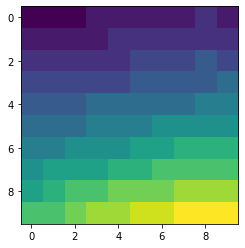

In [6]:
plt.imshow(img)

In [7]:
# Colormap dictionary 

from tools.json2colorList import useSelectedColorsFunc

def generate_cmap_dict(colors, boundaries, jsonFile):
    
    # check error
    if boundaries.max() > 1 or boundaries.min() < 0:
        raise ValueError('boundaries should be between 0 and 1')
    
    #create color_list
    color_list = useSelectedColorsFunc(jsonFile, colors)
    
    #create a color dictionary
    cdict = {} #{} = dictionary
    cdict['red'] = []
    cdict['green'] = []
    cdict['blue'] = []
    for i in range(0, boundaries.shape[0]):
        cdict['red'].append([boundaries[i], color_list[i][0], color_list[i][0]])
        cdict['green'].append([boundaries[i], color_list[i][1], color_list[i][1]])
        cdict['blue'].append([boundaries[i], color_list[i][2], color_list[i][2]])
    
    return cdict

In [8]:
def normalize_image(image, vmax = None):
    if vmax is None:
        vmax = image.max()
    return image / vmax

## To-Do = Color maps shoudl be modified for negative / positive version!!!

In [33]:
# Custom colormap
# params
# Boundaries for including positive and negative values! (not abs!)
colors = ['TUI_blue_dark', 'TUI_blue_light', 'TUI_white', 'TUI_orange_light', 'TUI_orange_dark',  'TUI_red_dark']
boundaries = np.array([0.00, 0.45, 0.5, 0.6, 0.85, 1.00]) #[0.00, 0.43, 0.50, 0.57, 1.00]
jsonFile = 'tools/TUI_FRI_colors.json'

# generate
cdict = generate_cmap_dict(colors, boundaries, jsonFile)
cmp = LinearSegmentedColormap('my_cmp', segmentdata=cdict)

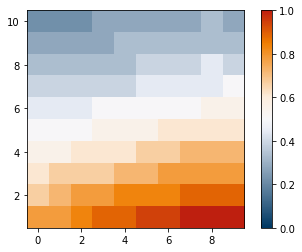

In [10]:
fig, ax = plt.subplots(1, 1)

im = ax.imshow(normalize_image(img), cmap = cmp, vmax = 1, vmin = 0)

ax.set_xticks(np.arange(0, 10, 2))
ax.set_xticklabels(np.arange(0, 10, 2))

ax.set_yticks(np.arange(0, 10, 2))
ax.set_yticklabels(np.arange(10, 0, -2))
fig.colorbar(im)

In [11]:
plt.close('all')

In [44]:
vmax = np.abs(A_true).max()
vmin = -vmax#A_true.min()

## Animation

In [90]:
ani_dtype = 'fk'
save = True
# resoluton: dots per inch (higher = better)
dpi = 250 

if ani_dtype == 'true':
    data = A_true
elif ani_dtype == 'smp':
    data = A_smp
elif ani_dtype == 'idw':
    data = A_idw
elif ani_dtype == 'fk':
    data = A_fk

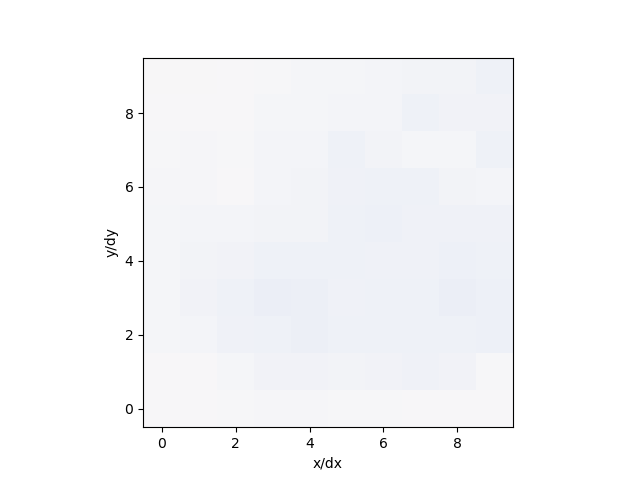

In [91]:
%matplotlib widget


# Animate C-Scans
fig, ax = plt.subplots(nrows = 1, ncols = 1)

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []

for timestep in range(300):
    # Choose the current frame
    z = timestep%300
    # Flip the y axis to align the CAD
    z_slice = get_cscanimg_png(data[z, :, :])
    # Imshow
    im = ax.imshow(z_slice, cmap = cmp, vmin = vmin, vmax = vmax, animated=True)

    # Add the current frame
    ims.append([im])

# Adjust the aspect ratio (AFTER imshow!!!)
ax.set_aspect(1)

# Other figure settings
#ax.set_title('Slices along z: A_{}'.format(ani_dtype))
ax.set_xlabel('x/dx')
ax.set_ylabel('y/dy')

# Ticks
ax.set_xticks(np.arange(0, 10, 2))
ax.set_xticklabels(np.arange(0, 10, 2))

ax.set_yticks(np.arange(9, 0, -2))
ax.set_yticklabels(np.arange(0, 10, 2))

# Color bar
if ani_dtype == 'true':
    fig.colorbar(im, ax=ax)

# Animate: interval determines the playback speed
# duration [ms] = interval [ms] * number of frames
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=0)

# Save
if save == True:
    ani.save('animation/cscans_{}.mp4'.format(ani_dtype), dpi=dpi)



In [92]:
plt.close('all')

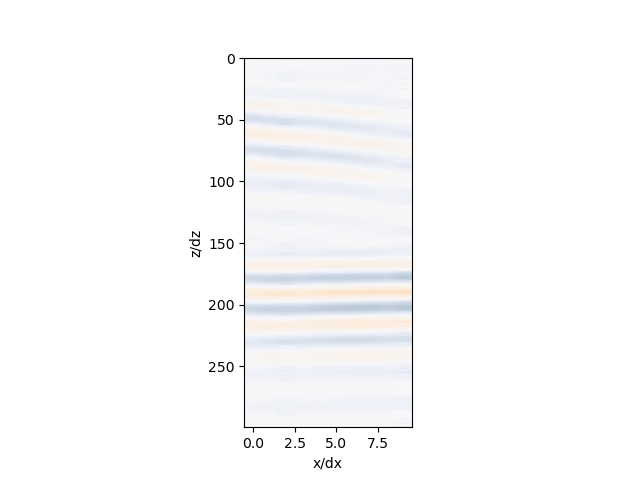

In [93]:
# Animate B-Scans

fig, ax = plt.subplots(nrows = 1, ncols = 1)

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []

for timestep in range(10):
    # Choose the current frame
    y = timestep%10
    im = ax.imshow(data[:300, :, y], cmap = cmp, vmin = vmin, vmax = vmax, animated=True)
    
    # Add the current frame
    ims.append([im])

# Adjust the aspect ratio (AFTER imshow!!!)
ax.set_aspect(dz/dx)

# Other figure settings
#ax.set_title('Slices along y: A_{}'.format(ani_dtype))
ax.set_xlabel('x/dx')
ax.set_ylabel('z/dz')

# Color bar
if ani_dtype == 'true':
    fig.colorbar(im, ax=ax)

# Animate: interval determines the playback speed
# duration [ms] = interval [ms] * number of frames 
ani1 = animation.ArtistAnimation(fig, ims, interval=1500, blit=False,
                                repeat_delay=0.01)

# Save
if save == True:
    ani1.save('animation/bscans_{}.mp4'.format(ani_dtype), dpi=dpi)

plt.show()

In [94]:
plt.close('all')